In [1]:
import torch
import torch.nn as nn
import torchvision

In [4]:
train_set = torchvision.datasets.CIFAR10('.', train=True, download=True)
test_set = torchvision.datasets.CIFAR10('.', train=False, download=True)

100%|██████████| 170M/170M [00:36<00:00, 4.68MB/s] 


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [8]:
train_x, train_y = train_set.data, train_set.targets
test_x, test_y = test_set.data, test_set.targets

In [9]:
type(train_x), type(train_y)

(numpy.ndarray, list)

CNN Model:
    - 1 x Conv2d + BN + ReLU
    - 3 x (Conv2d + BN + ReLU)
    - MaxPool()
    - 5 x (Conv2d + BN + ReLU)
    - MaxPool()
    - 7 x (Conv2d + BN + ReLU)
    - Global Average Pool
    - FC + BN + RelU
    - Classification Layer

In [ ]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        self.block_1 = 3 * [
            nn.Conv2d(32, 32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ]
        self.pool1 = [nn.MaxPool2d(kernel_size=(2,2))]

        self.block_2 = 5 * [
            nn.Conv2d(32, 32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ]
        self.pool2 = [nn.MaxPool2d(kernel_size=(2,2))]

        self.block_3 = 7 * [
            nn.Conv2d(32, 32, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        ]
        self.avgpool = [nn.AdaptiveAvgPool2d((1,1))]
        
        self.features = nn.Sequential(
            *self.block_1,
            *self.pool1,
            *self.block_2,
            *self.pool2,
            *self.block_3,
            *self.avgpool,
            )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            nn.Linear(128, num_classes),
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        return self.fc(x)

In [3]:
model = CNNModel()

In [4]:
model

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (features): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [ ]:
H, W, C
C, H, W

In [5]:
from torchinfo import summary

summary(model.to('cuda'), input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [1, 10]                   --
├─Sequential: 1-1                        [1, 32, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 32, 256, 256]         896
│    └─BatchNorm2d: 2-2                  [1, 32, 256, 256]         64
│    └─ReLU: 2-3                         [1, 32, 256, 256]         --
├─Sequential: 1-2                        [1, 32, 1, 1]             --
│    └─Conv2d: 2-4                       [1, 32, 256, 256]         9,248
│    └─BatchNorm2d: 2-5                  [1, 32, 256, 256]         64
│    └─ReLU: 2-6                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-7                       [1, 32, 256, 256]         (recursive)
│    └─BatchNorm2d: 2-8                  [1, 32, 256, 256]         (recursive)
│    └─ReLU: 2-9                         [1, 32, 256, 256]         --
│    └─Conv2d: 2-10                      [1, 32, 256, 256]     

1. __init__
2. __len__
3. __getitem__

## Image Classification Dataset
- Image
- Label

In [ ]:
from glob import glob

dataset_path = '/home/ahanaf/Datasets/STL10/train/'

image_paths = sorted(glob(f'{dataset_path}/*/*'))
labels = [int(x.split('/')[-2]) - 1 for x in image_paths]
len(image_paths)

In [127]:
from torch.utils.data import Dataset
import cv2

def load_image(path, image_size):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image_size, image_size))
    return image


class MyDataset(Dataset):
    def __init__(self, image_paths, labels, image_size, transforms=None):
        super().__init__()
        self.image_paths = image_paths
        self.labels = labels
        self.image_size = image_size
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image = load_image(self.image_paths[index], image_size=self.image_size)
        label = self.labels[index]

        if self.transforms is not None:
            image = self.transforms(image)

        return image, label
    



In [128]:
from torchvision import transforms


train_transforms = transforms.Compose([
    transforms.ToTensor(),
])

In [129]:
train_dataset = MyDataset(image_paths=image_paths, labels=labels, image_size=256, transforms=train_transforms)

In [130]:
it = iter(train_dataset)

torch.Size([3, 256, 256]) 0


Text(0.5, 1.0, '0')

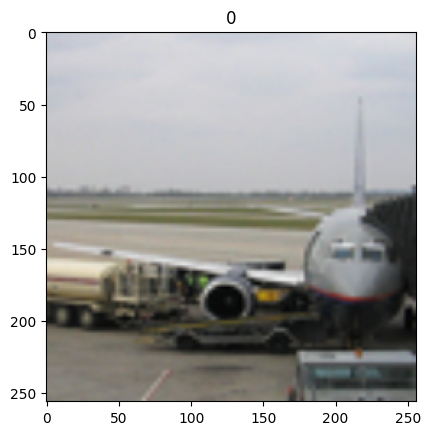

In [134]:
x, y = next(it)
print(x.shape, y)
import matplotlib.pyplot as plt
plt.imshow(x.permute(1, 2, 0))
plt.title(y)

In [135]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [136]:
it = iter(train_loader)

torch.Size([16, 3, 256, 256]) tensor([3, 4, 2, 2, 9, 3, 1, 2, 2, 4, 5, 8, 4, 0, 7, 6])


Text(0.5, 1.0, 'tensor(3)')

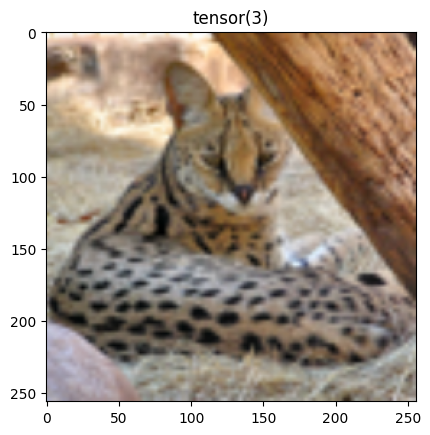

In [140]:
x, y = next(iter(train_loader))
print(x.shape, y)
import matplotlib.pyplot as plt
plt.imshow(x[0].permute(1,2,0))
plt.title(y[0])

In [ ]:
import numpy as np
num_epochs = 10
batch_size = 128

num_train = train_x.shape[0]
print(num_train)


def train_epoch(loader):
    model.train()
    losses = []
    num_train = images.shape[0]
    for images, labels in loader:
        x = images.to('cuda')
        y = labels.to('cuda')

        outputs = model(x)
        loss = loss_fn(outputs, y)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)


def validation_epoch(loader):
    model.eval()
    losses = []
    num_samples = images.shape[0]
    for images, labels in loader:
        x = images.to('cuda')
        y = labels.to('cuda')

        with torch.inference_mode():
            outputs = model(x)
        loss = loss_fn(outputs, y)

        losses.append(loss.item())
    return np.mean(losses)


for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    
    loss = train_epoch(images=train_x, labels=train_y)
    val_loss = validation_epoch(test_x, test_y)
    
    print(f'Train Loss: {loss:0.4f} | Val Loss: {val_loss:0.4f}')
